In [133]:
# Импорт необходимых библиотек.
import sqlite3
import os
import pandas as pd
import matplotlib.pyplot as plt

# Пути до файлов.
folder = os.getcwd()

sql_folder = fr'{folder}\SQL'

files_folder = fr'{folder}\files'
if not os.path.exists(files_folder):
    os.mkdir(files_folder)

db = fr'{folder}\db\testDB.sqlite3'

# Создание подключения к БД.
conn = sqlite3.connect(db)


In [134]:
# Функция для сокращения наименования тарифа.
# Берем строку, начиная с "сроком на...".
def clear_name(string):
    temp = string.split()
    return ' '.join(temp[4:])


# Функция для получения укрупненной категории наименования тарифа.
def tariff_name(string):
    if 'Лайт' in string:
        return 'lite tariff'
    elif 'Базовый' in string:
        return 'base tariff'
    elif 'ТД' in string:
        return 'td tariff'
    elif 'Максимальный' in string:
        return 'max tariff'
    else:
        return 'unknown tariff'


# Функция для получения продолжительности тарифа.
def tariff_duration(string):
    if 'на 6 мес.' in string:
        return '6 month'
    elif 'на 1 год' in string:
        return '1 year'
    elif 'на 1 мес.' in string:
        return '1 month'
    elif 'на 18 мес.' in string:
        return '18 month'
    elif 'на 2 года' in string:
        return '2 year'
    elif 'на 2 мес.' in string:
        return '2 month'
    elif 'на 3 мес.' in string:
        return '3 month'
    elif 'на 4 мес.' in string:
        return '4 month'
    else:
        return 'unknown duration'


# SQL запрос для получения продаж из таблицы "Счета".
# Считаю, что, если есть оплаченный счет, то была подтвержденная продажа.
# Сам SQL запрос можно посмотреть в соответствующей папке.
# Берем только одну категорию продукта - "Бухгалтерия.Контур".
sql_sales = fr'{sql_folder}\sales.sql'
sales = open(sql_sales).read()

# Создаем датафрейм, помещаем в него результат выполнения SQL запроса.
df_sales = pd.read_sql_query(sales, conn)
# Преобразуем дату выставления счета и оплаты счета в тип "дата".
df_sales[['BDate', 'PayDate']] = df_sales[['BDate', 'PayDate']].apply(pd.to_datetime)

# Выделяем из даты выставления счета соответствующий месяц для анализа.
df_sales['month_bill'] = df_sales['BDate'].dt.month

# Выделяем из даты выставления счета соответствующий год для анализа.
df_sales['year_bill'] = df_sales['BDate'].dt.year

# Выделяем из даты оплаты счета соответствующий месяц для анализа.
# Заменяем пустые значения на 0.
# Преобразуем к типу "int".
df_sales['month_pay'] = df_sales['PayDate'].dt.month
df_sales['month_pay'].fillna(0, inplace=True)
df_sales['month_pay'] = df_sales['month_pay'].astype('int64')

# Выделяем из даты оплаты счета соответствующий год для анализа.
# Заменяем пустые значения на 0.
# Преобразуем к типу "int".
df_sales['year_pay'] = df_sales['PayDate'].dt.year
df_sales['year_pay'].fillna(0, inplace=True)
df_sales['year_pay'] = df_sales['year_pay'].astype('int64')

# Создаем новый стобец с сокращенным наименованием тарифа.
df_sales['new_name'] = df_sales['piName'].apply(clear_name)

# Создаем новый столбец с категорией тарифа.
df_sales['tariff_name'] = df_sales['new_name'].apply(tariff_name)

# Создаем новыйц столбец с продолжительностью тарифа.
df_sales['tariff_duration'] = df_sales['new_name'].apply(tariff_duration)

# Запишем датафрейм в csv для анализа либо для построения дашбордов в других системах.
df_sales.to_csv(fr'{files_folder}\sales.csv', index=False, sep=';', encoding='utf-8')


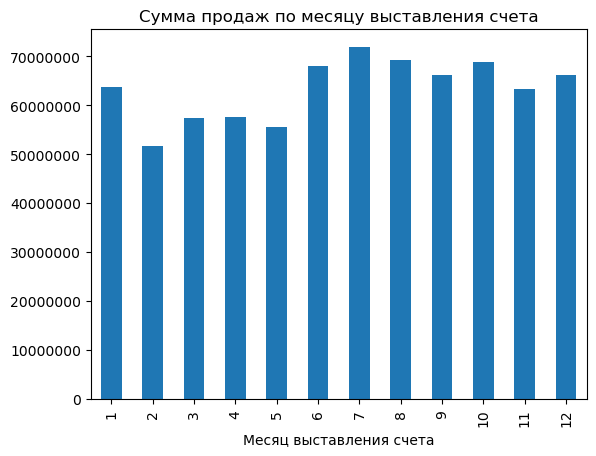

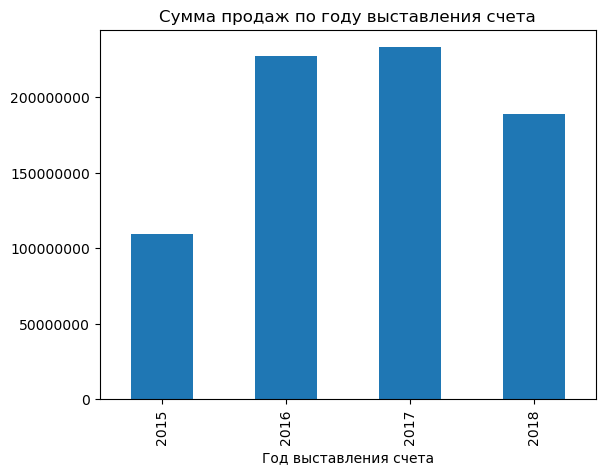

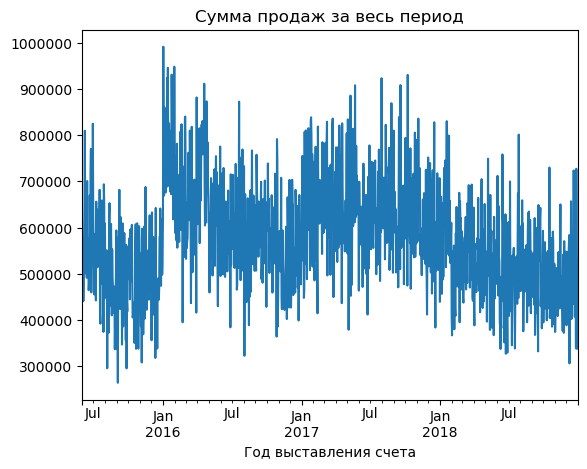

In [145]:
# Создадим два датафрейма с суммированием продаж по выставленным счетам.
# По месяцу выставления счета.
df_sum_by_bill_month = df_sales[['Cost', 'month_bill']].groupby('month_bill')['Cost'].agg('sum')
# По году выставления счета.
df_sum_by_bill_year = df_sales[['Cost', 'year_bill']].groupby('year_bill')['Cost'].agg('sum')

# И построим два соответствующих графика.
df_sum_by_bill_month.plot(kind = 'bar')
plt.title('Сумма продаж по месяцу выставления счета')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Месяц выставления счета', horizontalalignment='center')
plt.show()

df_sum_by_bill_year.plot(kind = 'bar')
plt.title('Сумма продаж по году выставления счета')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Год выставления счета', horizontalalignment='center')
plt.show()

# Отдельный график по суммам продаж по выставленным счетам за весь период.
df_sales.groupby('BDate')['Cost'].agg('sum').plot(x='BDate', y='Cost')
plt.title('Сумма продаж за весь период')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Год выставления счета', horizontalalignment='center')
plt.show()


Исходя из графика видно, что второе полугодие более позитивно по суммам продаж, чем первое.
В 2016 году был резкий рост суммарного количества продаж по сравнению с 2015 годом.
В 2017 было небольшое увеличение, но уже в 2018 видим резкое падение сумм по продажам.

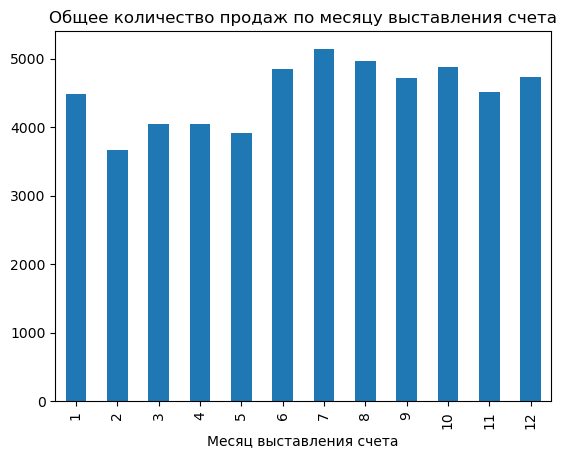

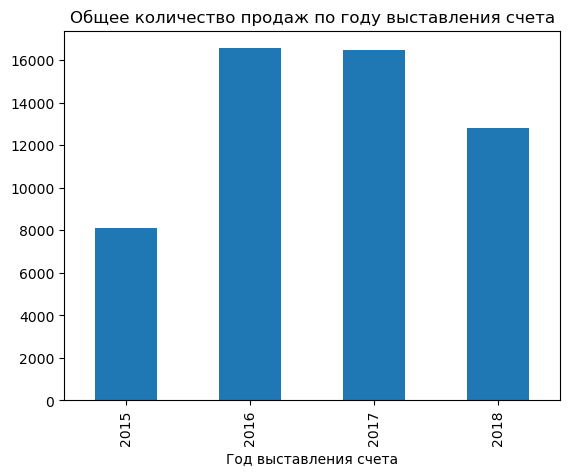

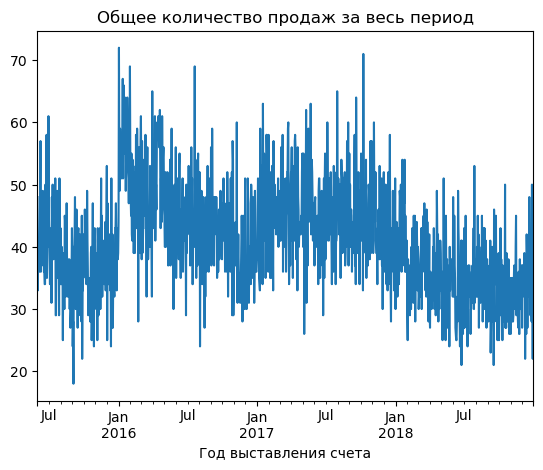

In [142]:
# Создадим два датафрейма с количеством продаж по выставленным счетам.
# По месяцу выставления счета.
df_count_by_bill_month = df_sales[['Cost', 'month_bill']].groupby('month_bill')['month_bill'].agg('count')
# По году выставления счета.
df_count_by_bill_year = df_sales[['Cost', 'year_bill']].groupby('year_bill')['year_bill'].agg('count')

# И построим два соответствующих графика.
df_count_by_bill_month.plot(kind = 'bar')
plt.title('Общее количество продаж по месяцу выставления счета')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Месяц выставления счета', horizontalalignment='center')
plt.show()

df_count_by_bill_year.plot(kind = 'bar')
plt.title('Общее количество продаж по году выставления счета')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Год выставления счета', horizontalalignment='center')
plt.show()

# Отдельный график по количеству продаж по выставленным счетам за весь период.
df_sales.groupby('BDate')['BDate'].agg('count').plot(x='BDate')
plt.title('Общее количество продаж за весь период')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Год выставления счета', horizontalalignment='center')
plt.show()


Аналогично предыдущим графикам видно, что второе полугодие более позитивно по количеству продаж, чем первое. 
В 2016 году был двукратный рост количества продаж по сравнению с 2015 годом. 
В 2017 небольшое падение количества продаж, но уже в 2018 видим более резкое падение количества продаж.

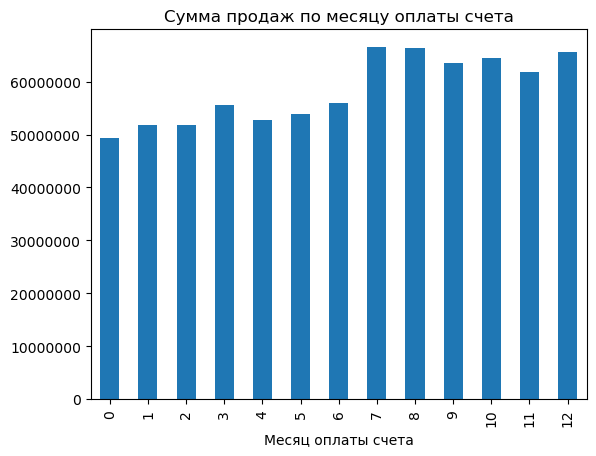

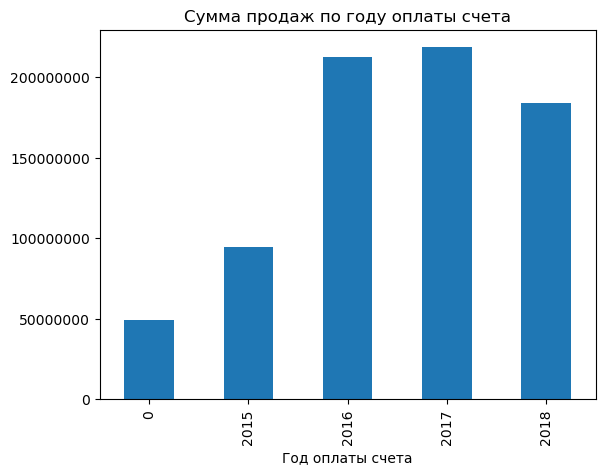

In [148]:
# Теперь проанализируем аналогичные показатели, но уже по дате оплаты счета.
# Создадим два датафрейма с суммированием продаж по оплаченным счетам.
# По месяцу оплаты счета.
df_pay_sum_by_month = df_sales[['Cost', 'month_pay']].groupby('month_pay')['Cost'].agg('sum')
# По году оплаты счета.
df_pay_sum_by_year = df_sales[['Cost', 'year_pay']].groupby('year_pay')['Cost'].agg('sum')

df_pay_sum_by_month.plot(kind = 'bar')
plt.title('Сумма продаж по месяцу оплаты счета')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Месяц оплаты счета', horizontalalignment='center')
plt.show()

df_pay_sum_by_year.plot(kind = 'bar')
plt.title('Сумма продаж по году оплаты счета')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Год оплаты счета', horizontalalignment='center')
plt.show()


Аналогично предыдущим выводам.
Во второй половине полугодия происходит рост сумм оплаты счетов.
2016 год по сравнению с 2015 годом принес двукратное увеличение сумм по оплаченным счетам.
Но в 2018 видно все то же падение.
Дополнительно стоит обратить внимание на столбец 0.
0 в данной ситуации означает, что счет был выставлен, но не оплачен.
Что-то услучилось при завершающем этапе сделки.
Необходимо разобраться в чем именно причина (не дорабатывают менеджеры?).
Так как, исходя из графиков, видно, что недополученная прибыль таким образом составляет 50'000'000.
Эта сумма практически равна всем продажам за январь или февраль.

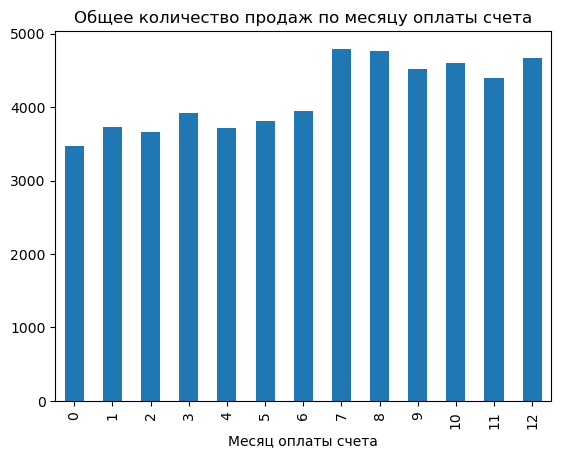

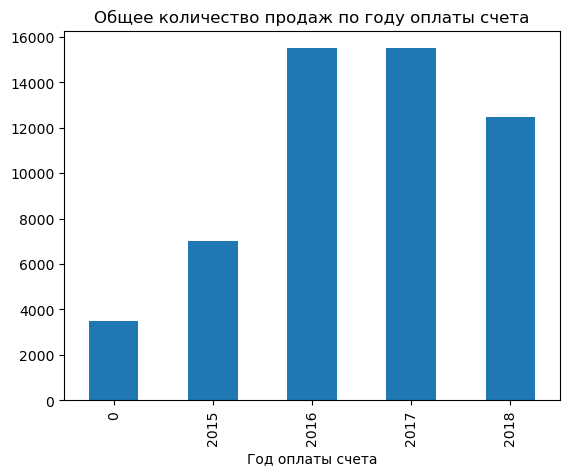

In [153]:
# Создадим два датафрейма с количеством продаж по оплаченным счетам.
# По месяцу оплаты счета.
df_pay_count_by_month = df_sales[['Cost', 'month_pay']].groupby('month_pay')['month_pay'].agg('count')
# По году оплаты счета.
df_pay_count_by_year = df_sales[['Cost', 'year_pay']].groupby('year_pay')['year_pay'].agg('count')

df_pay_count_by_month.plot(kind = 'bar')
plt.title('Общее количество продаж по месяцу оплаты счета')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Месяц оплаты счета', horizontalalignment='center')
plt.show()

df_pay_count_by_year.plot(kind = 'bar')
plt.title('Общее количество продаж по году оплаты счета')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Год оплаты счета', horizontalalignment='center')
plt.show()


Выводы аналогичны предыдущей ситуации.
Количество незавершенных сделок - около 3500.

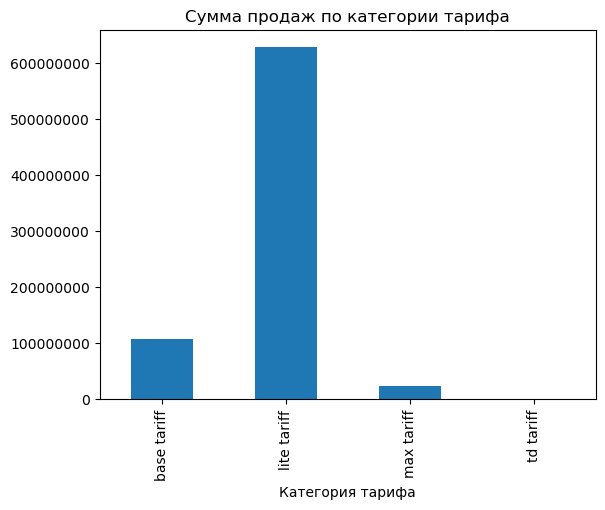

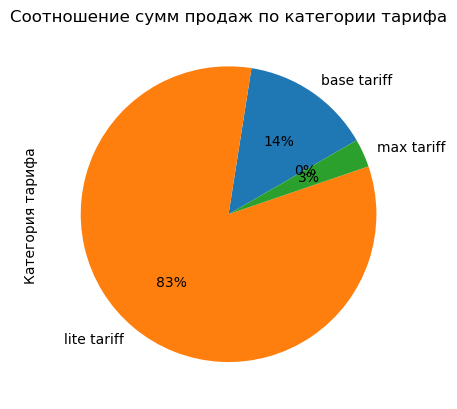

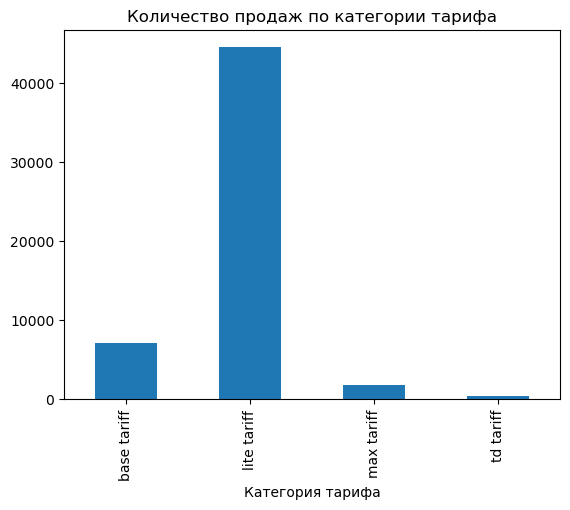

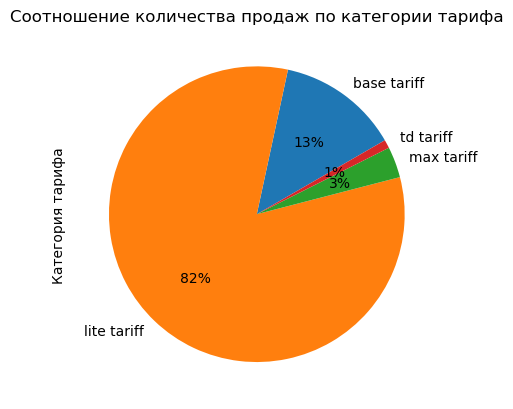

In [158]:
# Создадим два датафрейма по категориям тарифов.
# Сумма продаж по категории тарифа.
df_pay_sum_by_tariff_name = df_sales[['Cost', 'tariff_name']].groupby('tariff_name')['Cost'].agg('sum')
# Количество продаж по категории тарифа.
df_pay_count_by_tariff_name = df_sales[['Cost', 'tariff_name']].groupby('tariff_name')['tariff_name'].agg('count')

df_pay_sum_by_tariff_name.plot(kind = 'bar')
plt.title('Сумма продаж по категории тарифа')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Категория тарифа', horizontalalignment='center')
plt.show()

df_pay_sum_by_tariff_name.plot(kind='pie', autopct='%1.0f%%', startangle=30)
plt.title('Соотношение сумм продаж по категории тарифа')
plt.ylabel('Категория тарифа', horizontalalignment='center')
plt.show()

df_pay_count_by_tariff_name.plot(kind = 'bar')
plt.title('Количество продаж по категории тарифа')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Категория тарифа', horizontalalignment='center')
plt.show()

df_pay_count_by_tariff_name.plot(kind='pie', autopct='%1.0f%%', startangle=30)
plt.title('Соотношение количества продаж по категории тарифа')
plt.ylabel('Категория тарифа', horizontalalignment='center')
plt.show()


Исходя из графиков видно, что большую часть сумм и количества продаж составляет тариф "Лайт".
Остальные три тарифа идут с большим отставанием.
Нуобходимо обратить внимание на категорию "ТД". Есть ли вообще практический смысл присутствия такой отдельной категории.

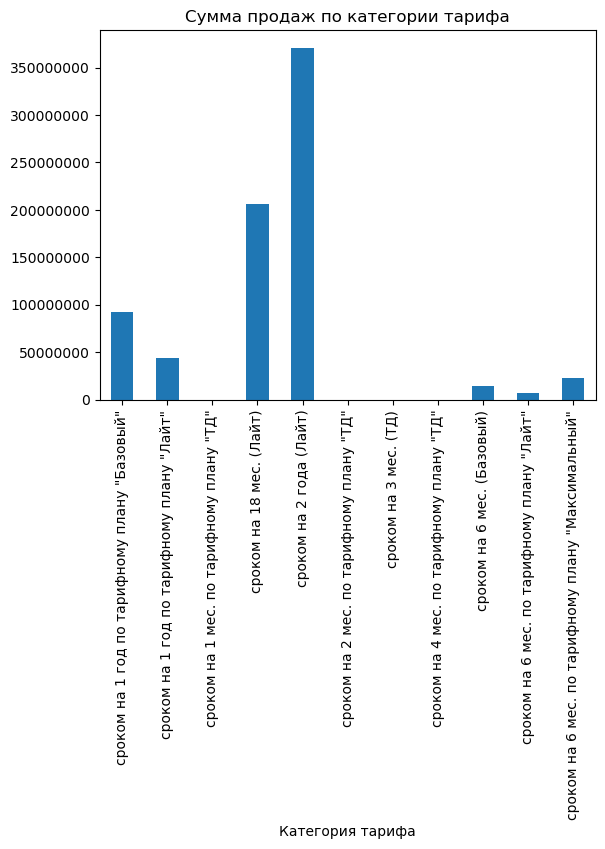

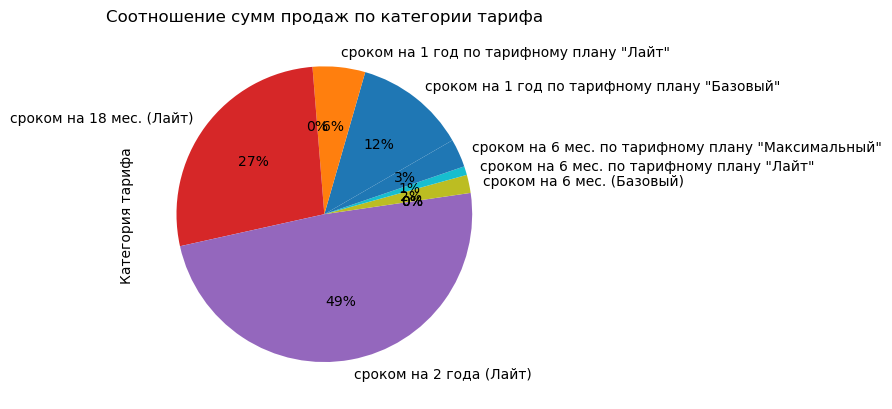

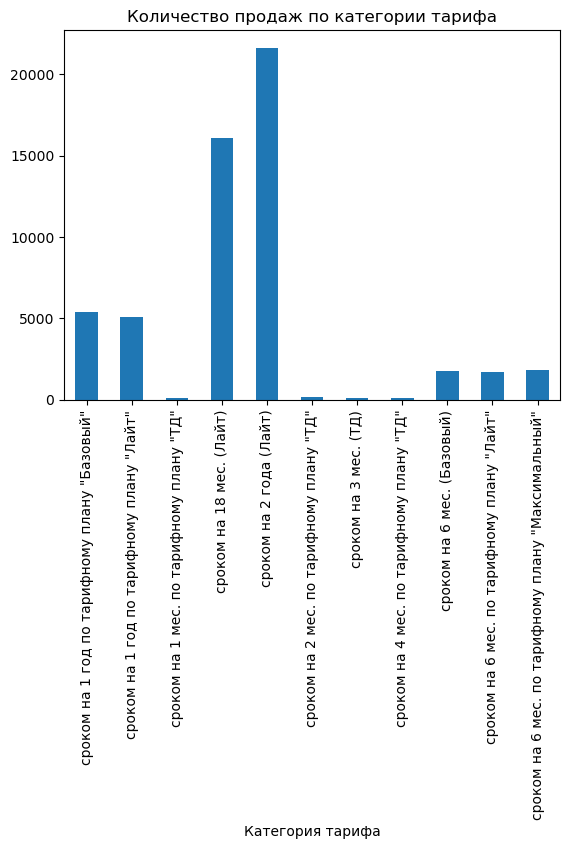

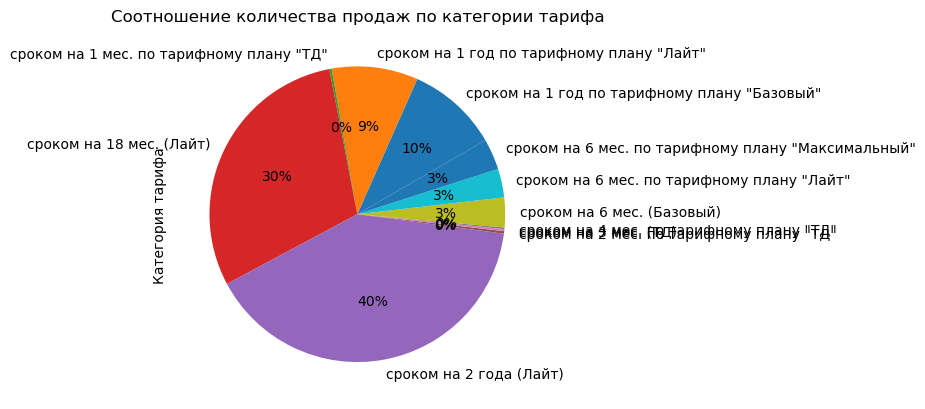

In [161]:
# Создадим два датафрейма по более детализированным категориям тарифов.
# Сумма продаж по категории тарифа.
df_pay_sum_by_name = df_sales[['Cost', 'new_name']].groupby('new_name')['Cost'].agg('sum')
# Количество продаж по категории тарифа.
df_pay_count_by_name = df_sales[['Cost', 'new_name']].groupby('new_name')['new_name'].agg('count')

df_pay_sum_by_name.plot(kind = 'bar')
plt.title('Сумма продаж по категории тарифа')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Категория тарифа', horizontalalignment='center')
plt.show()

df_pay_sum_by_name.plot(kind='pie', autopct='%1.0f%%', startangle=30)
plt.title('Соотношение сумм продаж по категории тарифа')
plt.ylabel('Категория тарифа', horizontalalignment='center')
plt.show()

df_pay_count_by_name.plot(kind = 'bar')
plt.title('Количество продаж по категории тарифа')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Категория тарифа', horizontalalignment='center')
plt.show()

df_pay_count_by_name.plot(kind='pie', autopct='%1.0f%%', startangle=30)
plt.title('Соотношение количества продаж по категории тарифа')
plt.ylabel('Категория тарифа', horizontalalignment='center')
plt.show()


Из графиков видим, что доминирующую позицию по суммам продаж занимает "сроком на 2 года (Лайт)", за ним следует "сроком на 18 месяцев (Лайт)".
Но в количественном выражении "сроком на 18 месяцев" отстает не так сильно от "сроком на 2 года" (см. график и круговую диаграмму).

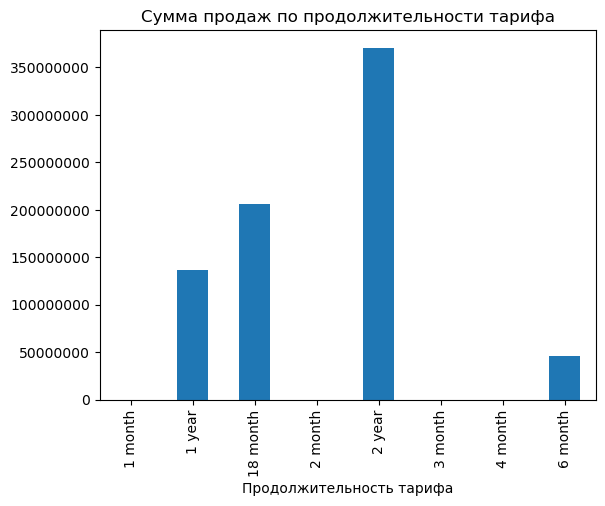

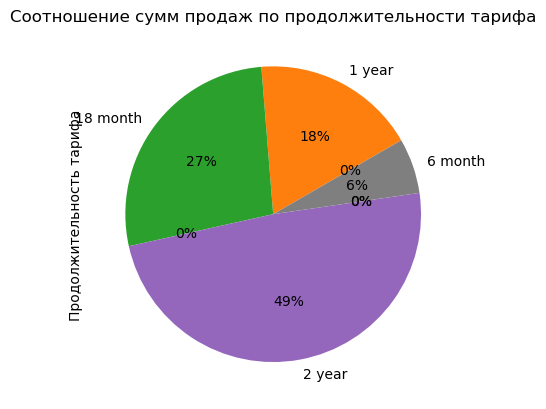

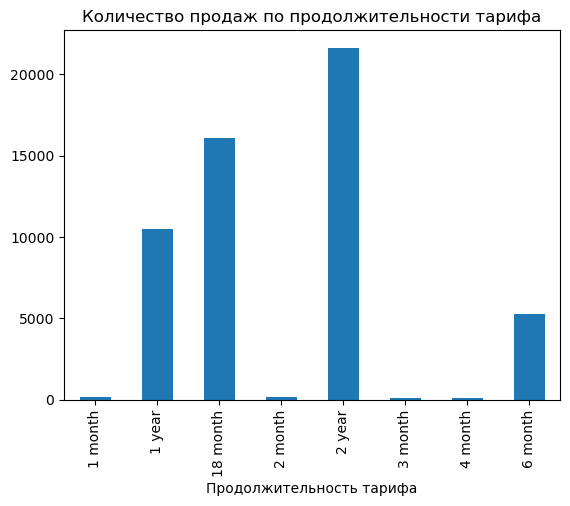

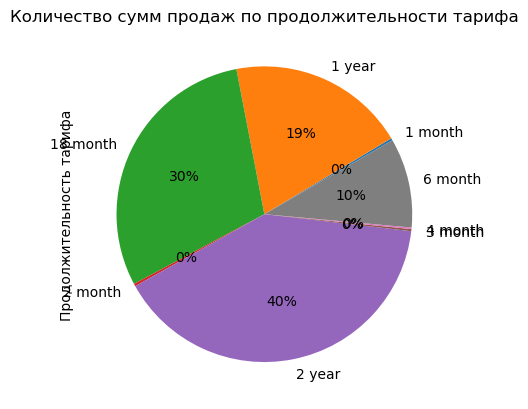

In [164]:
# И в завершение проанализируем период, на который приобретаются тарифы.
# Создадим два датафрейма по продолжительности тарифов.
# Сумма продаж по продолжительности тарифа.
df_pay_sum_by_tariff_duration = df_sales[['Cost', 'tariff_duration']].groupby('tariff_duration')['Cost'].agg('sum')
# Количество продаж по продолжительности тарифа.
df_pay_count_by_tariff_duration = df_sales[['Cost', 'tariff_duration']].groupby('tariff_duration')['tariff_duration'].agg('count')

df_pay_sum_by_tariff_duration.plot(kind = 'bar')
plt.title('Сумма продаж по продолжительности тарифа')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Продолжительность тарифа', horizontalalignment='center')
plt.show()

df_pay_sum_by_tariff_duration.plot(kind='pie', autopct='%1.0f%%', startangle=30)
plt.title('Соотношение сумм продаж по продолжительности тарифа')
plt.ylabel('Продолжительность тарифа', horizontalalignment='center')
plt.show()

df_pay_count_by_tariff_duration.plot(kind = 'bar')
plt.title('Количество продаж по продолжительности тарифа')
plt.ticklabel_format(style = 'plain', axis='y')
plt.xlabel('Продолжительность тарифа', horizontalalignment='center')
plt.show()

df_pay_count_by_tariff_duration.plot(kind='pie', autopct='%1.0f%%', startangle=30)
plt.title('Количество сумм продаж по продолжительности тарифа')
plt.ylabel('Продолжительность тарифа', horizontalalignment='center')
plt.show()


Проанализируем результаты графиков.
Доминирующее положение в сумме по продажам и в количестве продаж занимают тарифы продолжительностью 2 года.
Следом по популярности идут тарифы на 18 месяцев, 1 год и 6 месяцев.
Необходимо изучить целесообразность содержания таких тарифов, как тарифы на 1, 2, 3 и 4 месяца.
В количественном выражении их не так много.
Что касается суммарных продаж по данным тарифам, то круговая диаграмма показывает, что эти тарифы занимают долю на уровне погрешности.